In [1]:
import os
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc , logfbank
import librosa as lr
import os, glob, pickle
import librosa
from scipy import signal
import noisereduce as nr
from glob import glob
import librosa
get_ipython().magic('matplotlib inline')
#All the Required Packages and Libraies are installed.
import soundfile
from tensorflow.keras.layers import Conv2D,MaxPool2D, Flatten, LSTM
from keras.layers import Dropout,Dense,TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

/Users/guy07/Desktop/ser/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/ym/4v3mdpnj4qn5g4bsf8wdq5r80000gn/T/ipykernel_68656/3889644724.py:17: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('matplotlib inline')


In [3]:
os.listdir(path='speech-emotion-recognition-ravdess-data')
def getListOfFiles(dirName):
    listOfFile=os.listdir(dirName)
    allFiles=list()
    for entry in listOfFile:
        fullPath=os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles=allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

dirName = 'speech-emotion-recognition-ravdess-data'
listOfFiles = getListOfFiles(dirName)
len(listOfFiles)

1439

In [ ]:
import speech_recognition as sr
r=sr.Recognizer()
for file in range(0 , len(listOfFiles) , 1):
    with sr.AudioFile(listOfFiles[file]) as source:
        audio = r.listen(source)
        try:
            text = r.recognize_google(audio)
            print(text)
        except:
            print('error')

In [5]:
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

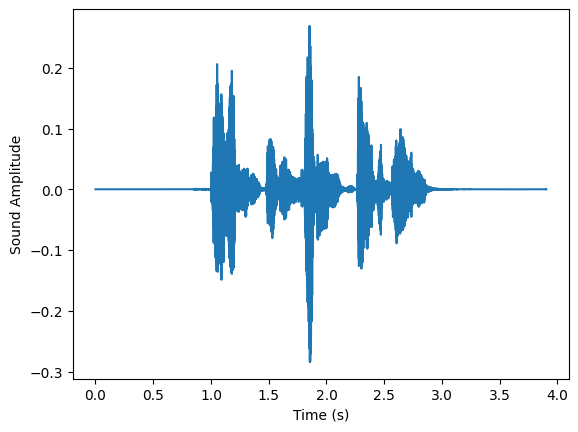

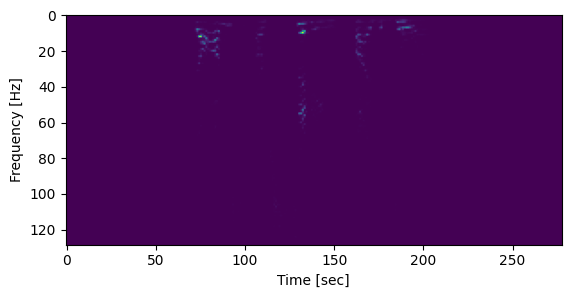

In [8]:
for file in range(0 , len(listOfFiles) , 1):
    audio , sfreq = lr.load(listOfFiles[file])
    time = np.arange(0 , len(audio)) / sfreq
    
    fig ,ax = plt.subplots()
    ax.plot(time , audio)
    ax.set(xlabel = 'Time (s)' , ylabel = 'Sound Amplitude')
    plt.show()
    break
    

for file in range(0 , len(listOfFiles) , 1):
     sample_rate , samples = wavfile.read(listOfFiles[file])
     frequencies , times, spectrogram = signal.spectrogram(samples, sample_rate) 
     plt.pcolormesh(times, frequencies, spectrogram)
     plt.imshow(spectrogram)
     plt.ylabel('Frequency [Hz]')
     plt.xlabel('Time [sec]')
     plt.show()
     break

In [9]:

def plot_signals(signals):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Time Series' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def plot_fft(fft):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transform' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y,freq = data[0] , data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq , Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1
    
def plot_fbank(fbank):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1
            
def plot_mfccs(mfccs):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Capstrum  Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                             cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n , d= 1/rate)
    Y= abs(np.fft.rfft(y)/n)
    return(Y,freq)

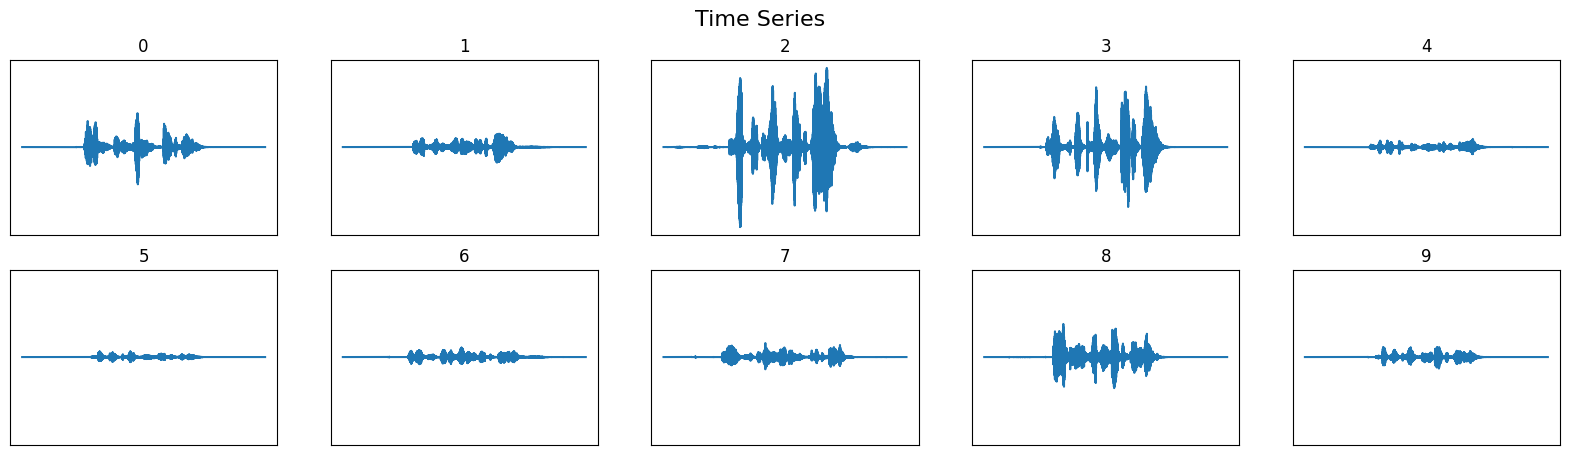

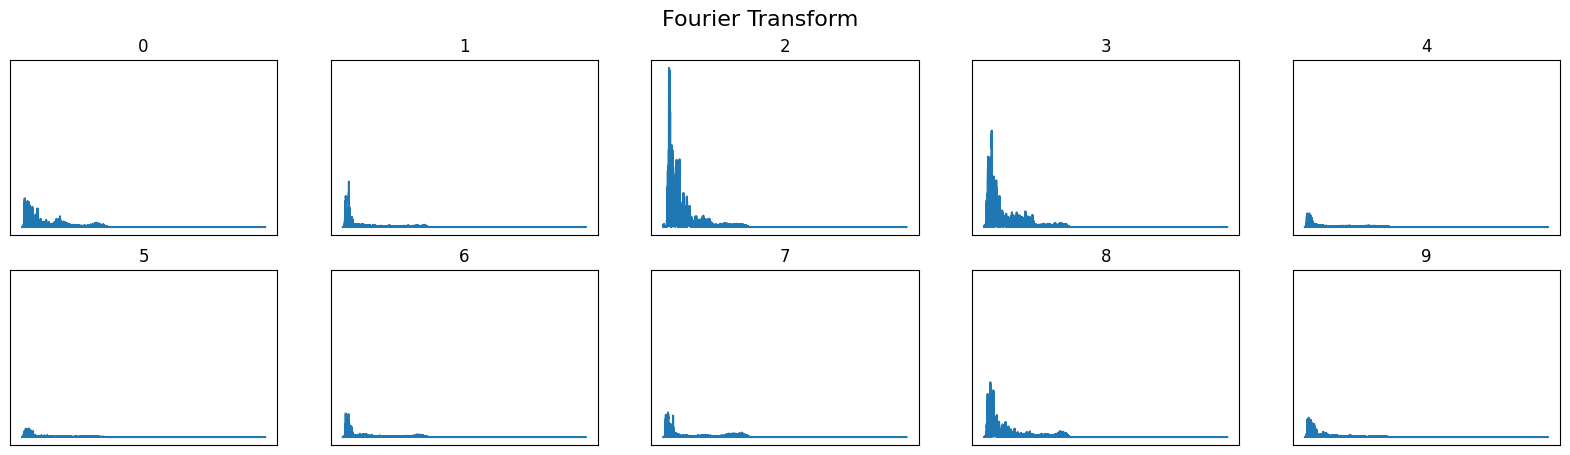

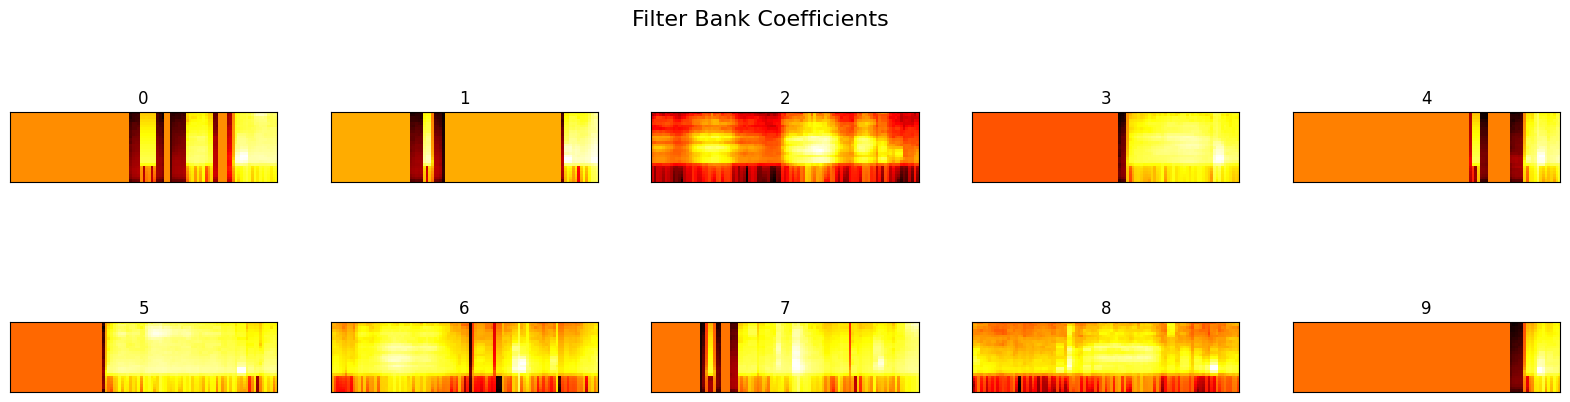

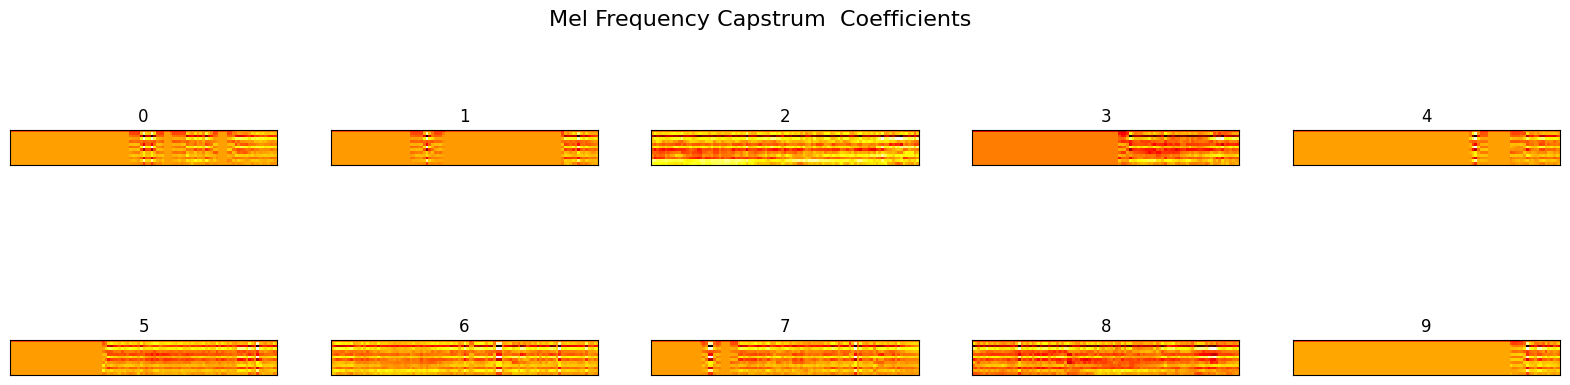

In [12]:
signals={}
fft={}
fbank={}
mfccs={}
# load data
for file in range(0 , len(listOfFiles) , 1):
#     rate, data = wavfile.read(listOfFiles[file])
     signal,rate =librosa.load(listOfFiles[file] , sr=44100)
     mask = envelope(signal , rate , 0.0005)
     signals[file] = signal
     fft[file] = calc_fft(signal , rate)
    
     bank = logfbank(signal[:rate] , rate , nfilt = 26, nfft = 1103).T
     fbank[file] = bank
     mel = mfcc(signal[:rate] , rate , numcep =13 , nfilt = 26 , nfft=1103).T
     mfccs[file]=mel

plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

In [13]:
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [14]:
import glob,pickle
for file in tqdm(glob.glob(r'C:\Users\Sakshi jain\speech-emotion-recognition-ravdess-data\\**\\*.wav')):
    file_name = os.path.basename(file)
    signal , rate = librosa.load(file, sr=16000)
    mask = envelope(signal,rate, 0.0005)
    wavfile.write(filename= r'C:\Users\Sakshi jain\clean_speech\\'+str(file_name), rate=rate,data=signal[mask])

0it [00:00, ?it/s]


In [19]:
# features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result

In [20]:

emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [21]:
from glob import glob
import os
import glob
def load_data(test_size=0.33):
    x,y=[],[]
    answer = 0
    for file in glob.glob('/Users/guy07/Desktop/ser/clean_speech/*.wav'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            answer += 1
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append([emotion,file_name])
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [22]:
#Split the dataset
import librosa
import numpy as np
x_train,x_test,y_trai,y_tes=load_data(test_size=0.25)
print(np.shape(x_train),np.shape(x_test), np.shape(y_trai),np.shape(y_tes))
y_test_map = np.array(y_tes).T
y_test = y_test_map[0]
test_filename = y_test_map[1]
y_train_map = np.array(y_trai).T
y_train = y_train_map[0]
train_filename = y_train_map[1]
print(np.shape(y_train),np.shape(y_test))
print(*test_filename,sep="\n")

(576, 180) (192, 180) (576, 2) (192, 2)
(576,) (192,)
03-01-03-02-02-01-16.wav
03-01-03-01-02-01-17.wav
03-01-03-01-02-02-05.wav
03-01-06-01-01-02-19.wav
03-01-02-02-01-01-19.wav
03-01-02-01-02-02-01.wav
03-01-07-01-02-01-17.wav
03-01-03-02-02-02-04.wav
03-01-03-02-02-01-14.wav
03-01-07-01-01-02-17.wav
03-01-07-02-02-01-12.wav
03-01-06-01-02-01-13.wav
03-01-07-02-01-02-09.wav
03-01-02-02-01-02-01.wav
03-01-06-02-01-01-12.wav
03-01-02-02-01-02-19.wav
03-01-06-01-02-02-03.wav
03-01-03-01-02-02-13.wav
03-01-06-01-01-01-14.wav
03-01-06-02-01-02-14.wav
03-01-03-01-02-02-21.wav
03-01-06-02-02-02-23.wav
03-01-06-02-02-01-07.wav
03-01-07-02-01-01-21.wav
03-01-03-01-02-02-23.wav
03-01-06-02-02-02-24.wav
03-01-06-02-02-01-06.wav
03-01-03-01-02-01-13.wav
03-01-07-02-01-02-24.wav
03-01-02-02-01-02-23.wav
03-01-03-01-02-01-09.wav
03-01-03-01-02-02-14.wav
03-01-06-01-01-02-04.wav
03-01-03-02-01-01-02.wav
03-01-03-01-01-01-15.wav
03-01-02-02-02-01-02.wav
03-01-03-02-02-01-05.wav
03-01-07-01-02-01-11.

In [23]:
print((x_train[0], x_test[0]))
#number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

(array([-3.90711548e+02,  4.63122864e+01, -2.51764641e+01, -3.83111382e+00,
       -1.75483227e+01, -3.19253902e+01, -2.38653374e+01, -2.12510452e+01,
       -9.19464207e+00, -1.29695063e+01, -1.92252884e+01, -3.70474815e+00,
       -2.09867115e+01,  9.58110452e-01, -2.16735516e+01, -5.31903410e+00,
       -1.10358839e+01, -1.03974533e+01, -1.19409599e+01, -8.03185558e+00,
       -1.37130079e+01, -7.08648062e+00, -8.36725616e+00,  2.27544975e+00,
        9.75155413e-01,  1.17445765e+01,  5.38146257e+00,  9.60692787e+00,
        6.95992517e+00,  9.21212196e+00,  1.02973766e+01,  1.20698681e+01,
        9.84880543e+00,  8.19135571e+00,  2.30051208e+00,  3.31454563e+00,
        4.71673822e+00,  4.91703415e+00,  2.95189667e+00, -3.65188271e-02,
        4.31435674e-01,  4.05591279e-01,  3.96214724e-01,  3.96962643e-01,
        4.28109407e-01,  4.97069418e-01,  5.28852880e-01,  6.03578568e-01,
        6.23844326e-01,  5.69440782e-01,  5.70043862e-01,  4.93273020e-01,
        5.22305936e-06, 

In [24]:

# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [25]:
#Train the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [26]:

#SAVING THE MODEL
import pickle

Pkl_Filename = "Emotion_Voice_Detection_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

In [27]:
with open(Pkl_Filename, 'rb') as file:  
    Emotion_Voice_Detection_Model = pickle.load(file)

Emotion_Voice_Detection_Model

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [28]:
#predicting :
y_pred=Emotion_Voice_Detection_Model.predict(x_test)
y_pred

array(['happy', 'happy', 'fearful', 'fearful', 'fearful', 'calm',
       'fearful', 'happy', 'happy', 'fearful', 'disgust', 'calm',
       'disgust', 'calm', 'fearful', 'calm', 'fearful', 'happy',
       'fearful', 'fearful', 'happy', 'fearful', 'fearful', 'disgust',
       'fearful', 'fearful', 'fearful', 'disgust', 'disgust', 'calm',
       'disgust', 'happy', 'happy', 'happy', 'happy', 'calm', 'happy',
       'disgust', 'calm', 'fearful', 'disgust', 'calm', 'fearful',
       'disgust', 'calm', 'disgust', 'disgust', 'fearful', 'fearful',
       'happy', 'calm', 'calm', 'happy', 'fearful', 'calm', 'fearful',
       'calm', 'fearful', 'happy', 'calm', 'calm', 'fearful', 'disgust',
       'disgust', 'fearful', 'calm', 'calm', 'fearful', 'happy', 'happy',
       'fearful', 'calm', 'calm', 'happy', 'calm', 'happy', 'happy',
       'fearful', 'disgust', 'calm', 'calm', 'calm', 'happy', 'disgust',
       'calm', 'happy', 'disgust', 'fearful', 'disgust', 'fearful',
       'calm', 'fearful', 

In [29]:
import numpy as np
import pandas as pd
y_pred1 = pd.DataFrame(y_pred, columns=['predictions'])
y_pred1['file_names'] = test_filename
print(y_pred1)
y_pred1.to_csv('predictionfinal.csv')

    predictions                file_names
0         happy  03-01-03-02-02-01-16.wav
1         happy  03-01-03-01-02-01-17.wav
2       fearful  03-01-03-01-02-02-05.wav
3       fearful  03-01-06-01-01-02-19.wav
4       fearful  03-01-02-02-01-01-19.wav
..          ...                       ...
187        calm  03-01-02-02-02-01-05.wav
188        calm  03-01-07-01-01-02-20.wav
189       happy  03-01-03-01-01-01-13.wav
190     disgust  03-01-07-01-02-01-02.wav
191     disgust  03-01-03-01-01-02-17.wav

[192 rows x 2 columns]


In [33]:
#RECORDED USING MICROPHONE:
import pyaudio
import wave

CHUNK = 1024 
FORMAT = pyaudio.paInt16 #paInt8
CHANNELS = 1 
RATE = 44100 #sample rate
RECORD_SECONDS = 4
WAVE_OUTPUT_FILENAME = "output10.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) #buffer

print("* recording")
frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


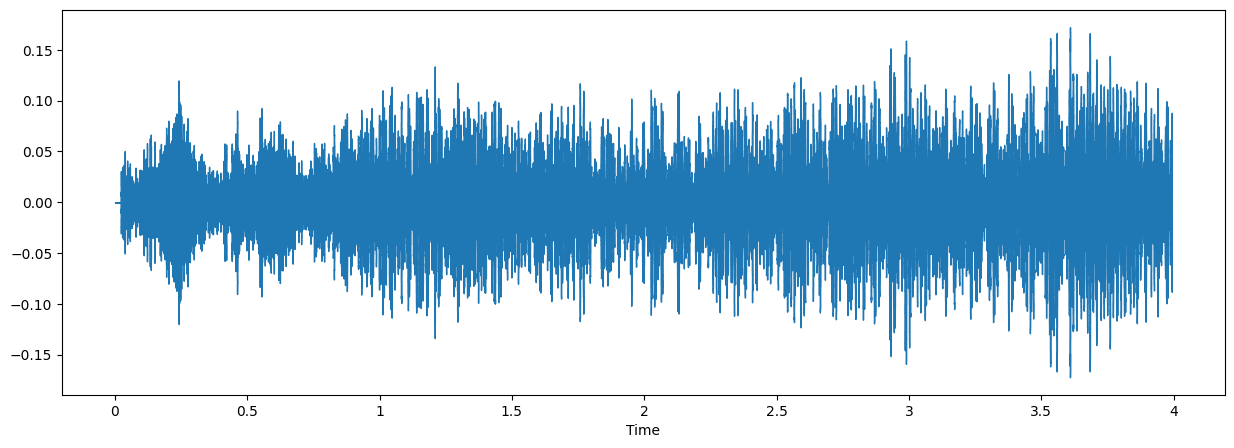

In [35]:
data, sampling_rate = librosa.load('output10.wav')
%matplotlib inline
import os
import pandas as pd
import librosa.display
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [47]:
file = 'output10.wav'
# data , sr = librosa.load(file)
# data = np.array(data)
ans =[]
new_feature  = extract_feature(file, mfcc=True, chroma=True, mel=True)
# ans.append(new_feature)
# ans = np.array(ans)
# data.shape

Emotion_Voice_Detection_Model.predict([new_feature])



array(['calm'], dtype='<U7')